In [1]:
!pip install prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load and preprocess data
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
df.columns = ['Month', 'Passengers']
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index.freq = 'MS'  # Set monthly start freq

# 📊 EDA

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


In [6]:
print(df.describe())

       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


In [7]:
df.isnull().sum()

,0
Passengers,0


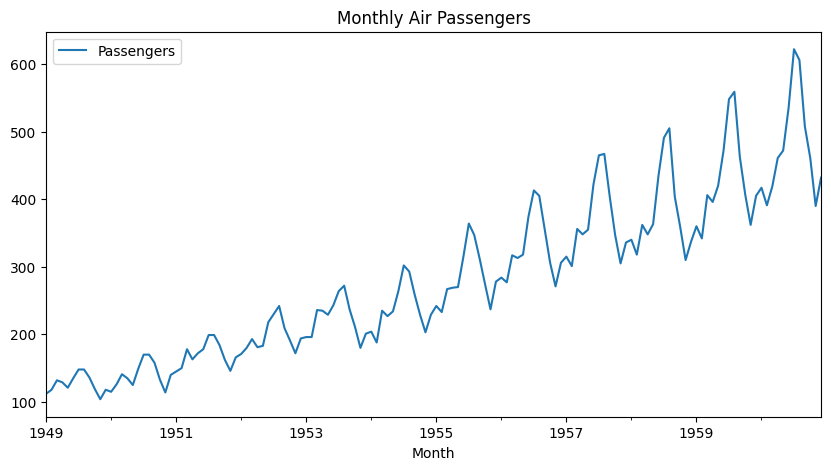

In [8]:
df.plot(figsize=(10,5), title='Monthly Air Passengers')
plt.show()

## 🔍 Stationarity Check using ADF Test

In [9]:
result = adfuller(df['Passengers'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print('❌ Series is Non-Stationary')
else:
    print('✅ Series is Stationary')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
❌ Series is Non-Stationary


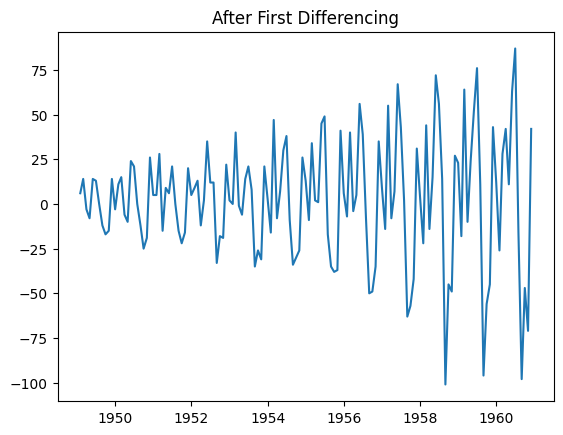

In [10]:
# Differencing to achieve stationarity
df_diff = df['Passengers'].diff().dropna()
plt.plot(df_diff)
plt.title('After First Differencing')
plt.show()

In [11]:
result = adfuller(df_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

if result[1] < 0.05:
    print("✅ The time series is now stationary (after 1nd differencing).")
else:
    print("❌ Still non-stationary (consider transformations like log or seasonal differencing).")


ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478
Critical Value (1%): -3.482
Critical Value (5%): -2.884
Critical Value (10%): -2.579
❌ Still non-stationary (consider transformations like log or seasonal differencing).


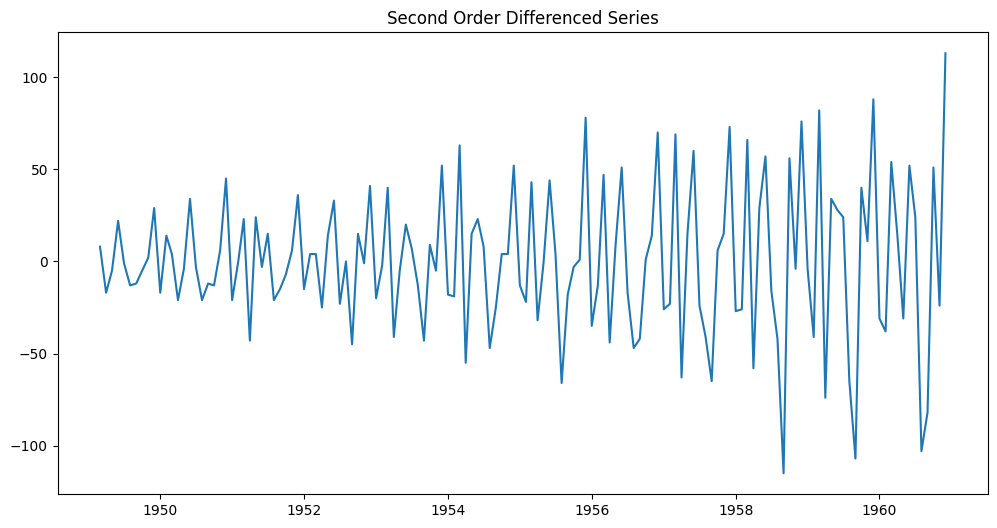

In [12]:
df_diff2 = df['Passengers'].diff().diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(df_diff2)
plt.title("Second Order Differenced Series")
plt.show()


In [13]:
result = adfuller(df_diff2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

if result[1] < 0.05:
    print("✅ The time series is now stationary (after 2nd differencing).")
else:
    print("❌ Still non-stationary (consider transformations like log or seasonal differencing).")


ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29
Critical Value (1%): -3.482
Critical Value (5%): -2.884
Critical Value (10%): -2.579
✅ The time series is now stationary (after 2nd differencing).


## 🔁 ACF & PACF for Model Order Selection

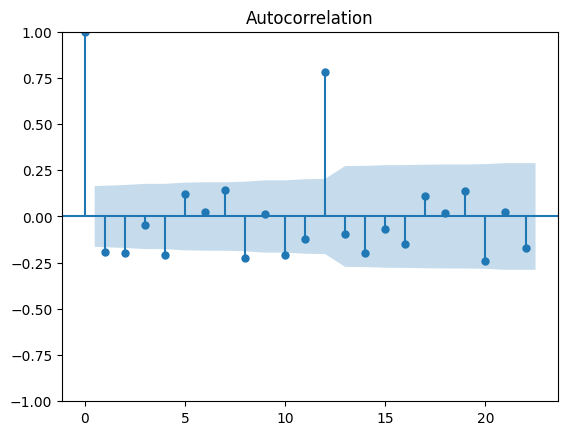

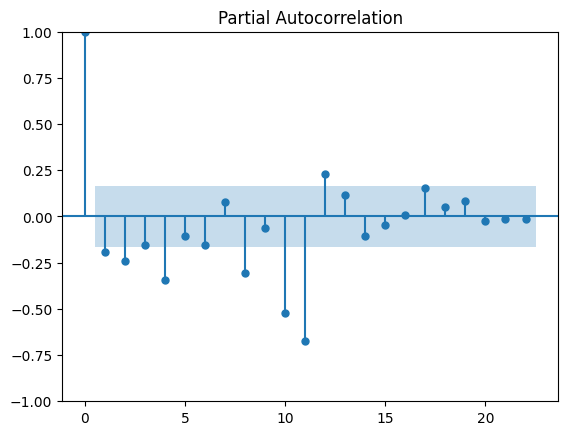

In [14]:
plot_acf(df_diff2)
plot_pacf(df_diff2)
plt.show()

## 🔧 ARIMA Model Forecast

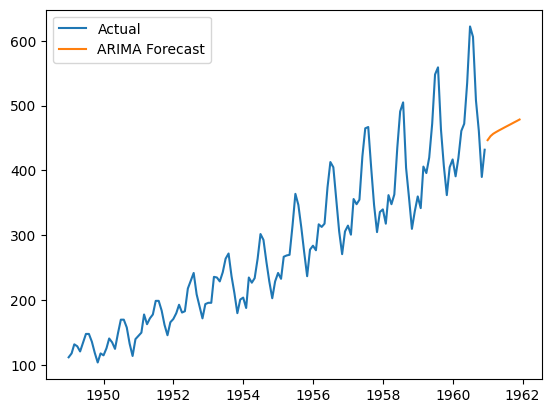

In [15]:
arima_model = ARIMA(df['Passengers'], order=(1,2,1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=12)
arima_forecast.index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
plt.plot(df, label='Actual')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

## 📘 SARIMA Model Forecast

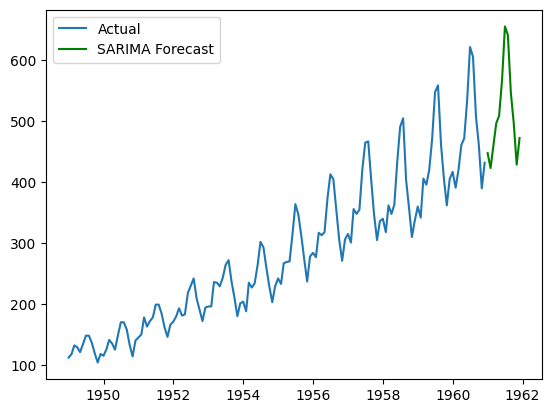

In [16]:
sarima_model = SARIMAX(df['Passengers'], order=(1,2,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=12)
sarima_forecast.index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
plt.plot(df, label='Actual')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='green')
plt.legend()
plt.show()

## 🔮 Prophet Forecasting

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsezxxg0y/2r4usqfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsezxxg0y/3qwlobqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32753', 'data', 'file=/tmp/tmpsezxxg0y/2r4usqfm.json', 'init=/tmp/tmpsezxxg0y/3qwlobqv.json', 'output', 'file=/tmp/tmpsezxxg0y/prophet_model9jph5ugn/prophet_model-20250413072502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


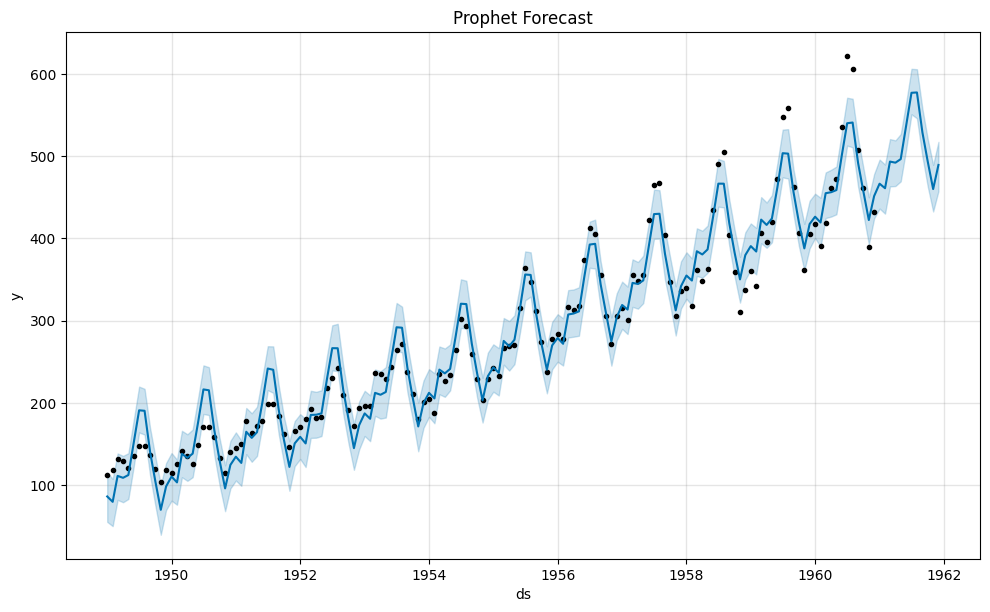

In [17]:
prophet_df = df.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
fig = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

## 📊 Model Forecast Comparison

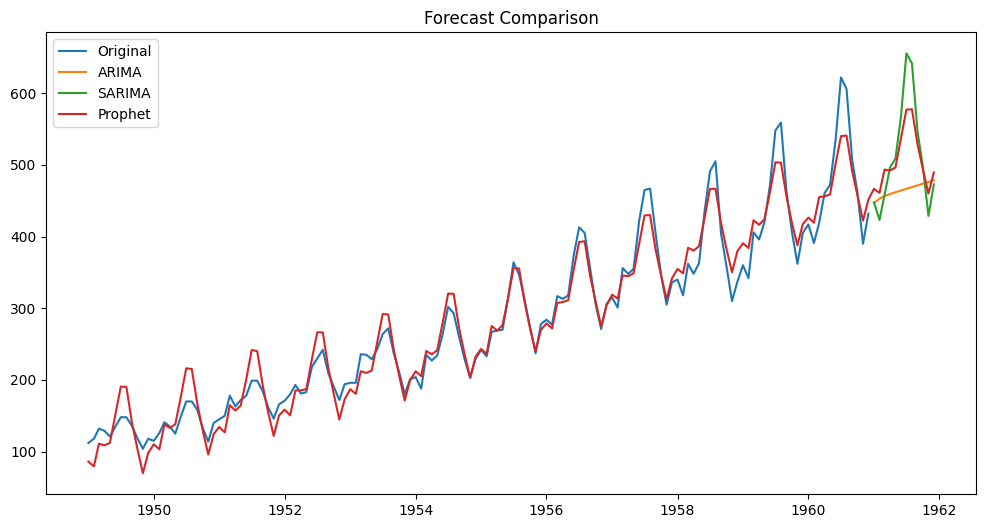

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df, label='Original')
plt.plot(arima_forecast, label='ARIMA')
plt.plot(sarima_forecast, label='SARIMA')
plt.plot(forecast.set_index('ds')['yhat'], label='Prophet')
plt.legend()
plt.title('Forecast Comparison')
plt.show()

## 📏 Evaluation Metrics (RMSE & MAE)

In [19]:
# Compare last 12 months of real data with predictions
actual = df[-12:]['Passengers']
arima_eval = arima_result.predict(start=len(df)-12, end=len(df)-1)
sarima_eval = sarima_result.predict(start=len(df)-12, end=len(df)-1)
prophet_eval = forecast.set_index('ds')['yhat'][-24:-12]

for name, pred in zip(['ARIMA', 'SARIMA', 'Prophet'], [arima_eval, sarima_eval, prophet_eval]):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    print(f'{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}')

ARIMA → RMSE: 49.70, MAE: 42.33
SARIMA → RMSE: 20.06, MAE: 15.35
Prophet → RMSE: 36.67, MAE: 28.66


## ✅ Final Results Summary

| Model   | RMSE   | MAE   | Notes                                  |
|---------|--------|-------|----------------------------------------|
| ARIMA   |  49.70 | 42.33 | Simple, needs data to be stationary    |
| SARIMA  |  20.06 | 15.35 | Handles seasonality better             |
| Prophet |  36.67 | 28.66 | Intuitive for trend + seasonality      |

✔️ The dataset was made stationary using **2nd-order differencing**.  
✔️ Forecasts are visualized and evaluated using **RMSE** and **MAE**.  
✔️ **SARIMA or Prophet** typically performs best for seasonal data like this.
